In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pingouin as pg
import numpy as np
from scipy.stats import spearmanr
import os
import shutil
from tqdm import tqdm
import random
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression


## Load all collected data from csv file

#### Firstly, load file with summary metrics with repo and source code files

In [3]:
absolute_file_path = '/Users/rmgaliullin/cam_data_600k/data/all.csv'
origin_all_data = pd.read_csv(absolute_file_path)

/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/3946247047.py:2: DtypeWarning: Columns (15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  origin_all_data = pd.read_csv(absolute_file_path)


#### Secondly, get files from each repo separetaly and mearch with comman table

In [4]:
df = origin_all_data[["repo", "java_file"]]
columns = ['cc', 'nobl', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl']

merged_df = df.copy()
for i in columns:
    temp = pd.read_csv(f"/Users/rmgaliullin/cam_data_600k/data/{i}.csv")
    temp = temp.drop_duplicates(['repo', 'java_file'])
    merged_df = pd.merge(merged_df, temp, on=['repo', 'java_file'], how='inner')

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606000 entries, 0 to 605999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   repo       606000 non-null  object 
 1   java_file  606000 non-null  object 
 2   cc         606000 non-null  int64  
 3   nobl       606000 non-null  int64  
 4   loc        606000 non-null  int64  
 5   hse        606000 non-null  float64
 6   hsd        606000 non-null  float64
 7   hsv        606000 non-null  float64
 8   coco       606000 non-null  int64  
 9   midx       606000 non-null  float64
 10  nocl       606000 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 50.9+ MB


#### Validate that concatenated repo data is equal to data in all-data table (drop test repo "yegor256/jaxec")

In [6]:
joint_values = pd.merge(origin_all_data, merged_df, on=['repo', 'java_file'], suffixes=('_df1', '_df2'), how='right')
joint_values = joint_values[joint_values['repo'] != 'yegor256/jaxec']

assert (joint_values['cc_df1'].astype(int) == joint_values['cc_df2']).all()
assert (joint_values['coco_df1'].astype(int) == joint_values['coco_df2']).all()
assert (joint_values['hsv_df1'].astype(float) == joint_values['hsv_df2']).all()
assert (joint_values['hse_df1'].astype(float) == joint_values['hse_df2']).all()
assert (joint_values['hsd_df1'].astype(float) == joint_values['hsd_df2']).all()
assert (joint_values['loc_df1'].astype(int) == joint_values['loc_df2']).all()
assert (joint_values['nobl_df1'].astype(int) == joint_values['nobl_df2']).all()
assert (joint_values['midx_df1'].astype(float) == joint_values['midx_df2']).all()
assert (joint_values['nocl_df1'].astype(int) == joint_values['nocl_df2']).all()

merged_df = merged_df[merged_df['repo'] != 'yegor256/jaxec']

In [7]:
result_df = merged_df.copy()
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605966 entries, 17 to 605999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   repo       605966 non-null  object 
 1   java_file  605966 non-null  object 
 2   cc         605966 non-null  int64  
 3   nobl       605966 non-null  int64  
 4   loc        605966 non-null  int64  
 5   hse        605966 non-null  float64
 6   hsd        605966 non-null  float64
 7   hsv        605966 non-null  float64
 8   coco       605966 non-null  int64  
 9   midx       605966 non-null  float64
 10  nocl       605966 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 55.5+ MB


## Reorgonize collected data

#### Exclude 2 lines of the signuter and of the last "\}" in order to work only with **body** of the method

In [8]:
result_df['loc'] = (result_df['loc'] - 2).clip(lower=0)

#### Add column with blank line ratio (aka bl_ratio) = nobl / loc, and comment line ratio (aka cl_ratio) = nocl / loc,

In [9]:
result_df.loc[:, "bl_ratio"] = result_df["nobl"] / result_df["loc"]
result_df.loc[:, "cl_ratio"] = result_df["nocl"] / result_df["loc"]

### Split dataset into 3 groups:
- _group A_ (aka subset_df) - all methods
- _group B_ (aka subset_df_3_40) - methods with 1 $\lt$ LoC $\le$ 42
- _group C_ (aka subset_df_3_40_with_non_zero_bl) methods with 1 $\lt$ LoC $\le$ 42 and NoBL $\gt$ 0

In [10]:
# Extract the relevant columns
selected_columns = ['cc', 'nobl', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'bl_ratio', 'cl_ratio']
subset_df = result_df[selected_columns]
subset_df_3_40 = subset_df[(subset_df['loc'] <= 42) & (subset_df['loc'] > 1)]
subset_df_3_40_with_non_zero_bl = subset_df_3_40[(subset_df['nobl'] > 1)]

/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/567013462.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset_df_3_40_with_non_zero_bl = subset_df_3_40[(subset_df['nobl'] > 1)]


#### Build additional set of the same groups with more coonditions
- nobl_[subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl] - same groups A, B, and C without column bl_ratio
- robl_[subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl] - same groups A, B, and C without column nobl and **finite**, **not null** bl_ratio values

In [11]:
nobl_subset_df = subset_df.drop(columns=['bl_ratio'], errors='ignore')
nobl_subset_df_3_40 = subset_df_3_40.drop(columns=['bl_ratio'], errors='ignore')
nobl_subset_df_3_40_with_non_zero_bl = subset_df_3_40_with_non_zero_bl.drop(columns=['bl_ratio'], errors='ignore')
nobl_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605966 entries, 17 to 605999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cc        605966 non-null  int64  
 1   nobl      605966 non-null  int64  
 2   loc       605966 non-null  int64  
 3   hse       605966 non-null  float64
 4   hsd       605966 non-null  float64
 5   hsv       605966 non-null  float64
 6   coco      605966 non-null  int64  
 7   midx      605966 non-null  float64
 8   nocl      605966 non-null  int64  
 9   cl_ratio  585613 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 67.0 MB


In [12]:
robl_subset_df = subset_df[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
robl_subset_df_3_40 = subset_df_3_40[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
robl_subset_df_3_40_with_non_zero_bl = subset_df_3_40_with_non_zero_bl[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
robl_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581948 entries, 18 to 605999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cc        581948 non-null  int64  
 1   loc       581948 non-null  int64  
 2   hse       581948 non-null  float64
 3   hsd       581948 non-null  float64
 4   hsv       581948 non-null  float64
 5   coco      581948 non-null  int64  
 6   midx      581948 non-null  float64
 7   nocl      581948 non-null  int64  
 8   bl_ratio  581948 non-null  float64
 9   cl_ratio  581948 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 48.8 MB


/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/3571949685.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  robl_subset_df_3_40 = subset_df_3_40[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')
/var/folders/_7/w61_y6mj5bgdr26d9sk7tmps8zhr5b/T/ipykernel_1627/3571949685.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  robl_subset_df_3_40_with_non_zero_bl = subset_df_3_40_with_non_zero_bl[np.isfinite(result_df['bl_ratio']) & ~result_df['bl_ratio'].isna()].drop(columns=['nobl'], errors='ignore')


## Extracting information from data

#### Build distribution plots for several complexition metrics between each group

In [13]:
def build_box_plot(metric, group_A, group_B, group_C, axis, bottom, top):
    data_A = group_A[[metric]].assign(Type="any method")
    data_B = group_B[[metric]].assign(Type="any NOBL")
    data_C = group_C[[metric]].assign(Type="NOBL = 0")

    # Concatenate the two subsets
    result_df = pd.concat([data_A, data_B, data_C], ignore_index=True)

    # Add another box plot for 'hsd' column where 'nobl' == 0 on the same axis
    sns.boxplot(data=result_df, y=metric, hue="Type")

    # Set labels and title
    axis.set_ylim(bottom=bottom, top=top) 
    axis.set_ylabel(metric.upper(), fontdict={'size':30, 'font':'times new roman'})
    axis.tick_params(labelsize=23)
    
    axis.set_xticks([]) 
    axis.get_legend().remove()

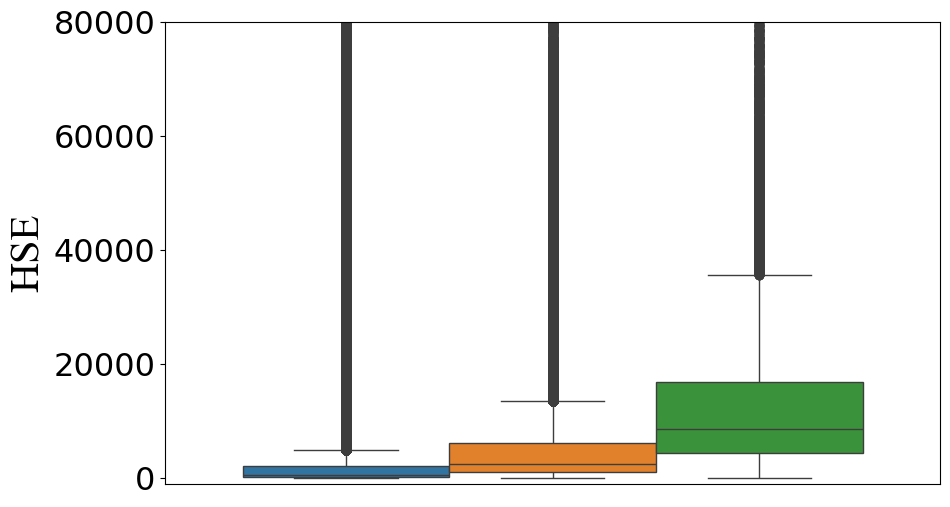

In [14]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('hse', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-1000, top=80000)
plt.show()

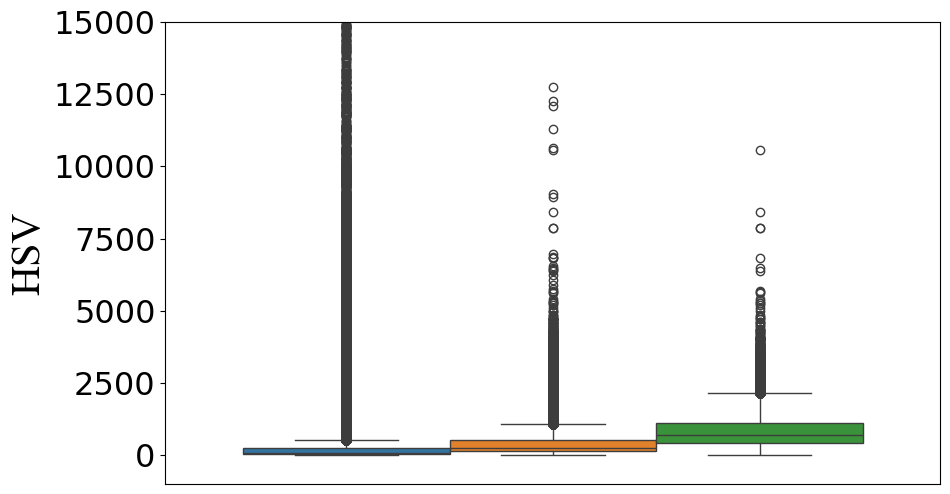

In [15]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('hsv', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-1000, top=15000)
plt.show()

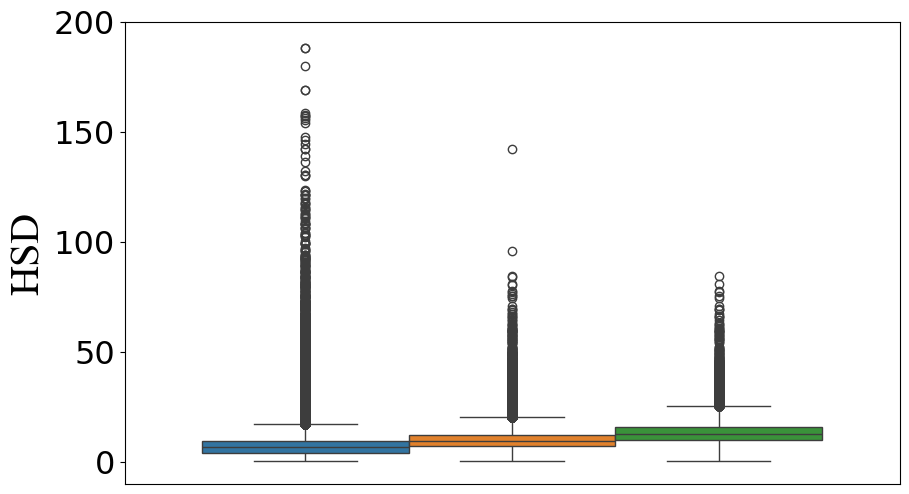

In [16]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('hsd', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-10, top=200)
plt.show()

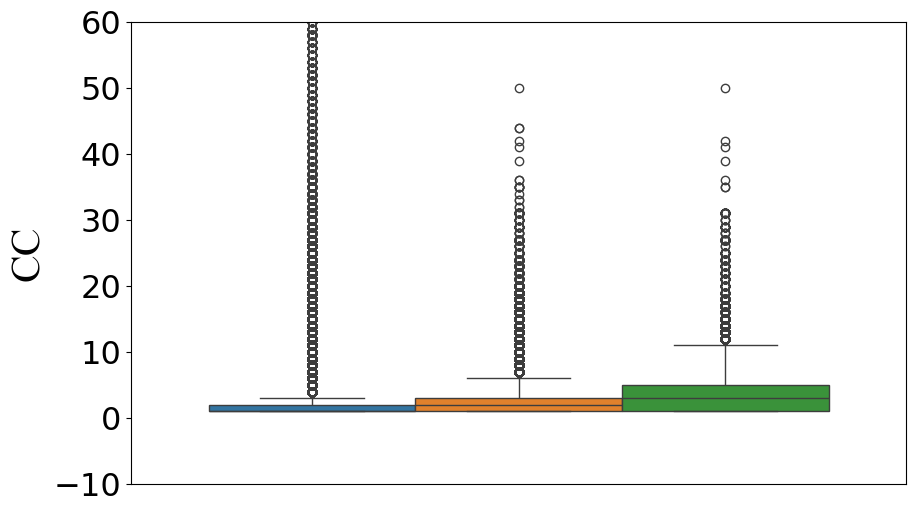

In [17]:
_, ax = plt.subplots(figsize=(10, 6))
build_box_plot('cc', subset_df, subset_df_3_40, subset_df_3_40_with_non_zero_bl, ax, bottom=-10, top=60)
plt.show()

## Building .dat files for paper plots

In [18]:
# Will use euclidean distance for points
def euclidean_distance_squared(p1, p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

In [19]:
# Метод, объединяющий точки в определенном радиусе в одну с сохранением информации о количестве точек в группе
def reduction(points, d):
    result = []
    d2 = d * d
    taken = [False] * len(points)
    for i, point in enumerate(tqdm(points)):
        if not taken[i]:
            merged_points_x = [point[0]]
            merged_points_y = [point[1]]
            taken[i] = True
            for j in range(i + 1, len(points)):
                if not taken[j] and euclidean_distance_squared(point, points[j]) <= d2:
                    taken[j] = True
                    merged_points_x.append(points[j][0])
                    merged_points_y.append(points[j][1])
            
            # print(f'INFO [reduction] merged {len(merged_points_x)} points, centered in {(sum(merged_points_x) / len(merged_points_x), sum(merged_points_y) / len(merged_points_y))}')
            # print(f'INFO [reduction] processed {i + 1} out of {len(points)} points')
            result.append((sum(merged_points_x) / len(merged_points_x), sum(merged_points_y) / len(merged_points_y), len(merged_points_x)))
    return result

In [20]:
# Метод, определяющий оптимальный радиус объединения точек, чтобы результурющее количество не превышало count. Радиус растет экспоненциально, на i итерации d_i = d * base ^ i
def find_best_reduction(points, base, split=1000000, d=None, count=350):
    if d is None:
        d = euclidean_distance_squared(points[0], points[-1]) / split
        
    random.shuffle(points)
    result = reduction(points, d)
    while (len(result) > count):
        print(f"INFO [find_best_reduction_settings] Current distance = {d}, size of data = {len(result)}, max value = {max(result)}")
        d *= base
        result = reduction(points, d)
    return result, d

In [44]:
def cluster_and_summarize(df, col1, col2, n_clusters):
    # Step 1: Normalize the specified columns for clustering purposes
    scaler = MinMaxScaler()
    df[[f'{col1}_norm', f'{col2}_norm']] = scaler.fit_transform(df[[col1, col2]])

    # Step 2: Apply K-Means clustering to create the desired number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df['cluster'] = kmeans.fit_predict(df[[f'{col1}_norm', f'{col2}_norm']])

    # Step 3: Calculate the number of points and center coordinates for each cluster
    # Group by cluster, get the count of points, and calculate the mean of col1 and col2
    cluster_info = df.groupby('cluster').agg(
        count=('cluster', 'size'),
        **{f'{col1}': (col1, 'mean'), f'{col2}': (col2, 'mean')}
    ).reset_index()
    
    cluster_info = cluster_info.drop(columns=['cluster'])

    return cluster_info

### Generate data in csv-files

In [48]:
force_rewrite_data = True

metrix_mapping = {'bl_ratio':'robl', 'cl_ratio':'rocl', 'nocl':'ncl', 'hse':'hse', 'hsd':'hsd', 'hsv':'hsv'}
data = {'groupA': nobl_subset_df} #,'groupB': nobl_subset_df_3_40,'groupC': nobl_subset_df_3_40_with_non_zero_bl}
distance_by_metric = {'cc': 0, 'loc':0.01, 'hse':30, 'hsd':0.1, 'hsv': 4.3, 'coco': 0, 'midx': 0.09}
step_by_metric = {'cc': 1.1, 'loc':1.1, 'hse':1.1, 'hsd': 1.2, 'hsv': 1.01, 'coco': 1.1, 'midx': 1.1}

In [51]:
# selected_columns ['cc', 'nobl', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'bl_ratio', 'cl_ratio']
for i in tqdm(['loc', 'hse', 'hsd', 'hsv', 'coco', 'midx']):
    for group, subset in data.items():
        if i == 'nobl':
            continue
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_nobl_{metrix_mapping.get(i, i)}.csv'
        best_values = cluster_and_summarize(subset, col1="nobl", col2=i, n_clusters=2000)
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = best_values.shape[0] > result_df_from_file.shape[0]
            
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')

        print(f"Done NOBL {i} number of points is {len(best_values)} in group {group}. It is more {more} than was")

 12%|█▎        | 1/8 [00:52<06:10, 52.99s/it]

Done NOBL loc number of points is 2000 in group groupA. It is more False than was


 25%|██▌       | 2/8 [01:42<05:06, 51.04s/it]

Done NOBL hse number of points is 2000 in group groupA. It is more False than was


 38%|███▊      | 3/8 [02:36<04:20, 52.18s/it]

Done NOBL hsd number of points is 2000 in group groupA. It is more False than was


 50%|█████     | 4/8 [03:27<03:27, 51.76s/it]

Done NOBL hsv number of points is 2000 in group groupA. It is more False than was


 62%|██████▎   | 5/8 [04:16<02:32, 50.82s/it]

Done NOBL coco number of points is 2000 in group groupA. It is more False than was


 75%|███████▌  | 6/8 [05:08<01:42, 51.17s/it]

Done NOBL midx number of points is 2000 in group groupA. It is more False than was


/Users/rmgaliullin/cam_data_600k/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (1253) found smaller than n_clusters (2000). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 88%|████████▊ | 7/8 [05:57<00:51, 51.03s/it]

Done NOBL nocl number of points is 1253 in group groupA. It is more False than was


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [52]:
for i in tqdm(['cc', 'nocl']):
    for group, subset in data.items():
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_nobl_{metrix_mapping.get(i, i)}.csv'
        best_values = subset[['nobl', i]].value_counts().reset_index(name='count')
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = len(best_values) > result_df_from_file.shape[0]
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')

        print(f"Done NOBL {i} using value counts {len(best_values)} in group {group}. It is more {more} than was")

100%|██████████| 2/2 [00:00<00:00, 36.58it/s]

Done NOBL cc using value counts 1577 in group groupA. It is more False than was
Done NOBL nocl using value counts 1253 in group groupA. It is more False than was


In [ ]:
force_rewrite_data = False

In [ ]:
# mapping = {'bl_ratio':'robl', 'cl_ratio':'rocl', 'nocl':'ncl', 'hse':'hse', 'hsd':'hsd', 'hsv':'hsv'}
# data = {'groupA': subset_df,'groupB': subset_df_3_40,'groupC': subset_df_3_40_with_non_zero_bl}

# for i in tqdm(selected_columns):
#     for group, subset in data.items():
#         if i == 'loc':
#             continue
        
#         file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_loc_{mapping.get(i, i)}.csv'
#         best_values, distance = find_best_reduction(subset[['loc', i]].drop_duplicates().values, 2, d=0.02, count=3000)
#         best_values.sort(key=lambda x:x[-1])
#         result_df_from_file = pd.read_csv(file_name, sep=' ')
#         more = len(best_values) > result_df_from_file.shape[0]
#         if force_rewrite_data or more:
#             result_df = pd.DataFrame(best_values, columns=['loc', mapping.get(i, i), 'count'])
#             result_df[mapping.get(i, i)] = result_df[mapping.get(i, i)].astype(int)
#             result_df.to_csv(file_name, index=False, sep=' ')
#         print(f"Done LOC {i} number of points is {len(best_values)} and distance is {distance} in group {group}. It is more {more} than was")

In [42]:
force_rewrite_data = True

metrix_mapping = {'bl_ratio':'robl', 'cl_ratio':'rocl', 'nocl':'ncl', 'hse':'hse', 'hsd':'hsd', 'hsv':'hsv'}
data = {'groupA': robl_subset_df} #,'groupB': robl_subset_df_3_40,'groupC': robl_subset_df_3_40_with_non_zero_bl}
distance_by_metric = {'cc': 0.00208, 'loc':0.01, 'hse':39.93, 'hsd':0.067, 'hsv': 1.43, 'coco': 0.0039, 'midx': 0.039, 'nocl':0.00159}
step_by_metric = {'cc': 1.01, 'loc':1.1, 'hse':1.1, 'hsd': 1.1, 'hsv': 1.01, 'coco': 1.1, 'midx': 1.1, 'nocl':1.1}

In [47]:
for i in tqdm(['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'cl_ratio']):
    for group, subset in data.items():
        if i == 'bl_ratio':
            continue
        
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_robl_{metrix_mapping.get(i, i)}.csv'
        best_values = cluster_and_summarize(subset, col1="bl_ratio", col2=i, n_clusters=2000)
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = best_values.shape[0] > result_df_from_file.shape[0]
            
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')
            
        print(f"Done ROBL {i} number of points is {len(best_values)} in group {group}. It is more {more} than was")

 11%|█         | 1/9 [00:51<06:49, 51.14s/it]

Done ROBL cc number of points is 2000 in group groupA. It is more False than was


 22%|██▏       | 2/9 [01:39<05:47, 49.71s/it]

Done ROBL loc number of points is 2000 in group groupA. It is more False than was


 33%|███▎      | 3/9 [02:30<05:02, 50.37s/it]

Done ROBL hse number of points is 2000 in group groupA. It is more False than was


 44%|████▍     | 4/9 [03:22<04:13, 50.71s/it]

Done ROBL hsd number of points is 2000 in group groupA. It is more False than was


 56%|█████▌    | 5/9 [04:12<03:22, 50.67s/it]

Done ROBL hsv number of points is 2000 in group groupA. It is more False than was


 67%|██████▋   | 6/9 [05:02<02:31, 50.43s/it]

Done ROBL coco number of points is 2000 in group groupA. It is more False than was


 78%|███████▊  | 7/9 [05:53<01:41, 50.63s/it]

Done ROBL midx number of points is 2000 in group groupA. It is more False than was


 89%|████████▉ | 8/9 [06:42<00:50, 50.08s/it]

Done ROBL nocl number of points is 2000 in group groupA. It is more False than was


100%|██████████| 9/9 [07:31<00:00, 50.20s/it]

Done ROBL cl_ratio number of points is 2000 in group groupA. It is more True than was


In [46]:
for i in tqdm(['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'cl_ratio']):
    for group, subset in data.items():
        file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_robl_{metrix_mapping.get(i, i)}.csv'
        best_values = subset[['bl_ratio', i]].value_counts().reset_index(name='count')
        if len(best_values) > 3000:
            continue
        best_values = best_values.sort_values(by='count', ascending=False).reset_index(drop=True)
        result_df_from_file = pd.read_csv(file_name, sep=' ')
        more = len(best_values) > result_df_from_file.shape[0]
        if force_rewrite_data or more:
            result_df = best_values.rename(columns=metrix_mapping)
            result_df[metrix_mapping.get(i, i)] = result_df[metrix_mapping.get(i, i)].astype(int)
            result_df.to_csv(file_name, index=False, sep=' ')

        print(f"Done ROBL {i} using value counts {len(best_values)} in group {group}. It is more {more} than was")

100%|██████████| 9/9 [00:00<00:00, 32.95it/s]


In [65]:
# Define the parameters
first_options = ['nobl', 'robl']
second_options = ['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'ncl']

# Iterate over each combination of first and second
for first in first_options:
    for second in second_options:
        # Construct the file path
        input_file_path = f'/Users/rmgaliullin/cam_data_600k/small/groupA_{first}_{second}.csv'
        output_file_path = f'/Users/rmgaliullin/cam_data_600k/small/groupA_{first}_{second}_linereg.csv'

        # Check if the input file exists
        if not os.path.exists(input_file_path):
            print(f"File not found: {input_file_path}")
            continue
        
        # Read the data from the CSV file
        df = pd.read_csv(input_file_path, delimiter=" ")
        # Ensure the necessary columns exist
        if first not in df.columns or second not in df.columns:
            print(f"Columns {first} or {second} not found in {input_file_path}")
            continue

        # Prepare the data for linear regression
        x = df[[first]].values.reshape(-1, 1)  # Independent variable
        y = df[second].values  # Dependent variable

        # Normalize the independent variable (x)
        scaler = MinMaxScaler()
        x_normalized = scaler.fit_transform(x)

        # Perform linear regression
        model = LinearRegression(deg)
        model.fit(x_normalized, y)

        # Generate points for the regression line
        x_range_normalized = np.linspace(0, 1, 50).reshape(-1, 1)  # Normalized range for x
        y_pred = model.predict(x_range_normalized)

        # Inverse transform the normalized x_range to original scale for output
        x_range_original = scaler.inverse_transform(x_range_normalized)

        # Create a DataFrame for the results
        results_df = pd.DataFrame({
            first: x_range_original.flatten(),
            second: y_pred
        })

        # Save the results to a new CSV file with space as the separator
        results_df.to_csv(output_file_path, index=False, sep=" ")
        print(f"Saved linear regression results to: {output_file_path}")

Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_cc_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_loc_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hse_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hsd_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hsv_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_coco_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_midx_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_nobl_ncl_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/small/groupA_robl_cc_linereg.csv
Saved linear regression results to: /Users/rmgaliullin/cam_data_600k/smal

### Make dat-files from their csv examples

In [64]:
def copy_csv_to_dat(directory, depth=1):
    for root, dirs, files in os.walk(directory):
        current_depth = root[len(directory) + 1:].count(os.sep)
        print("inside")
        if current_depth > depth:
            continue
        for file in files:
            if file.endswith('.csv'):
                csv_file_path = os.path.join(root, file)
                dat_file_path = os.path.join(root, 'dat', file.replace('.csv', '.dat'))
                os.makedirs(os.path.dirname(dat_file_path), exist_ok=True)
                print(f"Copying CSV file '{csv_file_path}' to DAT file '{dat_file_path}'")
                with open(csv_file_path, 'r') as csv_file:
                    csv_content = csv_file.read()
                    with open(dat_file_path, 'w') as dat_file:
                        dat_file.write(csv_content)
                    
    
# Specify the directory path
directory_path = '/Users/rmgaliullin/cam_data_600k/small'

# Call the function to copy CSV files to DAT files at depth=1
copy_csv_to_dat(directory_path, depth=1)


inside
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupB_robl_midx.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupB_robl_midx.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupA_nobl_bl_ratio.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupA_nobl_bl_ratio.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupC_loc_midx.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupC_loc_midx.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupA_nobl_hse_linereg.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupA_nobl_hse_linereg.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupB_nobl_coco.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupB_nobl_coco.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupC_nobl_rocl.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupC_nobl_rocl.dat'
Copying CSV file '/Users/rmgali

In [24]:
control = 'loc'
features = ['nobl', 'bl_ratio']
metrics = ['cc', 'coco', 'hse', 'hsv', 'hsd', 'midx']

partial_correlations = []
# Iterate through feature and metric combinations
for feature in features:
    for metric in metrics:
        # Calculate partial correlation
        if feature == 'nobl':
            df = nobl_subset_df[:]
        else:
            df = robl_subset_df[:]
        partial_corr = pg.partial_corr(data=df, x=metric, y=feature)
        partial_corr['feature'] = feature
        partial_corr['metric'] = metric
        partial_correlations.append(partial_corr)

print("Correlation between method's property and metric of the code complexity, controlling loc value. All methods")
result_partial_corr = pd.concat(partial_correlations)
result_partial_corr.set_index(['feature', 'metric'], inplace=True)
result_partial_corr

Correlation between method's property and metric of the code complexity, controlling loc value. All methods


n         r           CI95%         p-val
feature  metric                                                
nobl     cc      605966  0.356849    [0.35, 0.36]  0.000000e+00
         coco    605966  0.301803      [0.3, 0.3]  0.000000e+00
         hse     605966  0.325400    [0.32, 0.33]  0.000000e+00
         hsv     605966  0.584066    [0.58, 0.59]  0.000000e+00
         hsd     605966  0.523015    [0.52, 0.52]  0.000000e+00
         midx    605966 -0.583841  [-0.59, -0.58]  0.000000e+00
bl_ratio cc      581948  0.104245     [0.1, 0.11]  0.000000e+00
         coco    581948  0.073003    [0.07, 0.08]  0.000000e+00
         hse     581948  0.025450    [0.02, 0.03]  5.440311e-84
         hsv     581948  0.118576    [0.12, 0.12]  0.000000e+00
         hsd     581948  0.222138    [0.22, 0.22]  0.000000e+00
         midx    581948 -0.088927  [-0.09, -0.09]  0.000000e+00

In [34]:
# Create nested dictionary for nobl and robl dataframes
dataframes = {
    'nobl': {
        'groupA': nobl_subset_df,
        'groupB': nobl_subset_df_3_40,
        'groupC': nobl_subset_df_3_40_with_non_zero_bl
    },
    'bl_ratio': {
        'groupA': robl_subset_df,
        'groupB': robl_subset_df_3_40,
        'groupC': robl_subset_df_3_40_with_non_zero_bl
    }
}


# Define prefixes, features, and metrics
metrics = ['cc', 'coco', 'hse', 'hsv', 'hsd', 'midx']

# Initialize list to store partial correlation results
partial_correlations = []

# Loop through each prefix and its associated dataframes
for prefix, dfs in dataframes.items():
    for group_name, df in dfs.items():
        for metric in metrics:
            # Calculate partial correlation controlling for 'loc'
            partial_corr = pg.partial_corr(data=df, x=metric, y=prefix, covar='loc')
            
            # Add relevant identifiers directly in the DataFrame
            partial_corr['feature'] = prefix
            partial_corr['metric'] = metric
            partial_corr['group'] = group_name
            partial_corr['prefix'] = prefix  # Indicates whether it's 'nobl' or 'bl_ratio'
            
            # Append to the list
            partial_correlations.append(partial_corr)

# Concatenate and index results
result_partial_corr = pd.concat(partial_correlations)
result_partial_corr.set_index(['prefix', 'group', 'metric'], inplace=True)

# Display final result
print("Correlation between method's property and metric of the code complexity, controlling loc value. All methods")
result_partial_corr

Correlation between method's property and metric of the code complexity, controlling loc value. All methods


n         r           CI95%          p-val  \
prefix   group  metric                                                    
nobl     groupA cc      605966 -0.316423  [-0.32, -0.31]   0.000000e+00   
                coco    605966 -0.144818  [-0.15, -0.14]   0.000000e+00   
                hse     605966 -0.107408   [-0.11, -0.1]   0.000000e+00   
                hsv     605966 -0.092937   [-0.1, -0.09]   0.000000e+00   
                hsd     605966  0.078497    [0.08, 0.08]   0.000000e+00   
                midx    605966 -0.009569  [-0.01, -0.01]   9.385444e-14   
         groupB cc      258728 -0.184298  [-0.19, -0.18]   0.000000e+00   
                coco    258728 -0.144775  [-0.15, -0.14]   0.000000e+00   
                hse     258728  0.080963    [0.08, 0.08]   0.000000e+00   
                hsv     258728  0.142992    [0.14, 0.15]   0.000000e+00   
                hsd     258728  0.007690     [0.0, 0.01]   9.161057e-05   
                midx    258728 -0.034881  [-0.04, -0.03]   1.790928e-70   
         groupC cc       49640 -0.111985   [-0.12, -0.1]  3.011600e-138   
                coco     49640 -0.157704  [-0.17, -0.15]  7.905416e-274   
                hse      49640  0.067024    [0.06, 0.08]   1.574996e-50   
                hsv      49640  0.101638    [0.09, 0.11]  4.189331e-114   
                hsd      49640 -0.006222    [-0.02, 0.0]   1.656668e-01   
                midx     49640 -0.063654  [-0.07, -0.05]   9.687058e-46   
bl_ratio groupA cc      581948 -0.023333  [-0.03, -0.02]   6.805064e-71   
                coco    581948 -0.021652  [-0.02, -0.02]   2.662680e-61   
                hse     581948 -0.079630  [-0.08, -0.08]   0.000000e+00   
                hsv     581948 -0.052640  [-0.06, -0.05]   0.000000e+00   
                hsd     581948  0.146907    [0.14, 0.15]   0.000000e+00   
                midx    581948  0.081667    [0.08, 0.08]   0.000000e+00   
         groupB cc      258728 -0.110568  [-0.11, -0.11]   0.000000e+00   
                coco    258728 -0.105025   [-0.11, -0.1]   0.000000e+00   
                hse     258728  0.025013    [0.02, 0.03]   4.306995e-37   
                hsv     258728  0.097966     [0.09, 0.1]   0.000000e+00   
                hsd     258728  0.014127    [0.01, 0.02]   6.668960e-13   
                midx    258728  0.023524    [0.02, 0.03]   5.277506e-33   
         groupC cc       49640 -0.068641  [-0.08, -0.06]   6.477970e-53   
                coco     49640 -0.069292  [-0.08, -0.06]   6.829315e-54   
                hse      49640  0.083832    [0.08, 0.09]   4.091133e-78   
                hsv      49640  0.070627    [0.06, 0.08]   6.368993e-56   
                hsd      49640 -0.043879  [-0.05, -0.04]   1.364965e-22   
                midx     49640 -0.155628  [-0.16, -0.15]  1.228835e-266   

                         feature  
prefix   group  metric            
nobl     groupA cc          nobl  
                coco        nobl  
                hse         nobl  
                hsv         nobl  
                hsd         nobl  
                midx        nobl  
         groupB cc          nobl  
                coco        nobl  
                hse         nobl  
                hsv         nobl  
                hsd         nobl  
                midx        nobl  
         groupC cc          nobl  
                coco        nobl  
                hse         nobl  
                hsv         nobl  
                hsd         nobl  
                midx        nobl  
bl_ratio groupA cc      bl_ratio  
                coco    bl_ratio  
                hse     bl_ratio  
                hsv     bl_ratio  
                hsd     bl_ratio  
                midx    bl_ratio  
         groupB cc      bl_ratio  
                coco    bl_ratio  
                hse     bl_ratio  
                hsv     bl_ratio  
                hsd     bl_ratio  
                midx    bl_ratio  
         groupC cc      bl_ratio  
                coco   

In [56]:
def calculate_correlations(dataframes, metrics, method='pearson', return_full=False):
    """
    Calculate either Pearson or Spearman correlations for 'nobl' and 'bl_ratio' metrics across groups.

    Parameters:
    - dataframes: dict, nested dictionary of dataframes for each (group, prefix) pair
    - metrics: list, list of metrics to calculate correlations for
    - method: str, either 'pearson' or 'spearman'
    - return_full: bool, if True, returns the full correlation results instead of just the r value

    Returns:
    - DataFrame with multi-level columns for each group and feature, with correlation coefficients or full results
    """
    if method != 'pearson' and method != 'spearman':
        raise ValueError("Method must be 'pearson' or 'spearman'")
    results = {}

    # Loop through each prefix and its associated dataframes
    for prefix, dfs in dataframes.items():
        for group_name, df in dfs.items():
            group_results = []
            
            for metric in metrics:
                # Ensure the metric and prefix are treated as Series
                x = df[metric].values  # Convert to 1D numpy array for the metric
                y = df[prefix].values  # Convert to 1D numpy array for the prefix
                
                correlation = pg.corr(x=x, y=y, method=method)
                
                if return_full:
                    # Append full correlation result
                    group_results.append(correlation[['r', 'CI95%']])
                else:
                    # Extract only the correlation value (r)
                    r_value = correlation['r'].values[0]
                    group_results.append(r_value)
            
            # Store results with a multi-indexed Series for the group and prefix
            results[(group_name, prefix)] = pd.Series(group_results, index=metrics)

    # Convert results dictionary to a DataFrame with multi-level columns
    result_df = pd.DataFrame(results)
    
    # Set multi-level columns with first level as group and second level as 'nobl' or 'bl_ratio'
    result_df.columns.names = ['group', 'feature']
    
    return result_df

# Example usage:
# Define your dataframes and metrics
dataframes = {
    'nobl': {
        'groupA': nobl_subset_df,
        'groupB': nobl_subset_df_3_40,
        'groupC': nobl_subset_df_3_40_with_non_zero_bl
    },
    'bl_ratio': {
        'groupA': robl_subset_df,
        'groupB': robl_subset_df_3_40,
        'groupC': robl_subset_df_3_40_with_non_zero_bl
    }
}
metrics = ['cc', 'coco', 'hse', 'hsv', 'hsd', 'midx']

# Calculate Pearson correlation (just r values)
pearson_corr_result = calculate_correlations(dataframes, metrics, method='pearson')
print("Pearson Correlation (r values only):")
print(pearson_corr_result)

# Calculate Spearman correlation (just r values)
spearman_corr_result = calculate_correlations(dataframes, metrics, method='spearman')
print("\nSpearman Correlation (r values only):")
print(spearman_corr_result)

# Calculate full Pearson correlation results
full_pearson_result = calculate_correlations(dataframes, metrics, method='pearson', return_full=True)
print("\nFull Pearson Correlation Results:")
print(full_pearson_result)

# Calculate full Spearman correlation results
full_spearman_result = calculate_correlations(dataframes, metrics, method='spearman', return_full=True)
print("\nFull Spearman Correlation Results:")
print(full_spearman_result)


Pearson Correlation (r values only):
group      groupA    groupB    groupC    groupA    groupB    groupC
feature      nobl      nobl      nobl  bl_ratio  bl_ratio  bl_ratio
cc       0.356849  0.283058  0.205116  0.104245  0.056389 -0.334712
coco     0.301803  0.301604  0.190454  0.073003  0.058191 -0.348887
hse      0.325400  0.455861  0.366510  0.025450  0.156861 -0.267856
hsv      0.584066  0.543944  0.454342  0.118576  0.213930 -0.367099
hsd      0.523015  0.352822  0.262741  0.222138  0.129705 -0.300385
midx    -0.583841 -0.260665 -0.288931 -0.088927 -0.059114  0.123527

Spearman Correlation (r values only):
group      groupA    groupB    groupC    groupA    groupB    groupC
feature      nobl      nobl      nobl  bl_ratio  bl_ratio  bl_ratio
cc       0.447345  0.266146  0.235179  0.425537  0.197853 -0.426238
coco     0.443867  0.261469  0.218727  0.421987  0.192137 -0.454645
hse      0.504927  0.492064  0.455218  0.505636  0.413002 -0.491275
hsv      0.513503  0.516475  0.471252  0

In [ ]:
dataframes = {
    'nobl': {
        'groupA': nobl_subset_df,
        'groupB': nobl_subset_df_3_40,
        'groupC': nobl_subset_df_3_40_with_non_zero_bl
    },
    'bl_ratio': {
        'groupA': robl_subset_df,
        'groupB': robl_subset_df_3_40,
        'groupC': robl_subset_df_3_40_with_non_zero_bl
    }
}
metrics = ['loc', 'cc', 'coco', 'hse', 'hsv', 'hsd', 'midx', 'nocl']

# Calculate Pearson correlation
pearson_corr_result = calculate_correlations(dataframes, metrics, method='pearson')
print("Pearson Correlation:")
print(pearson_corr_result)

# Calculate Spearman correlation
spearman_corr_result = calculate_correlations(dataframes, metrics, method='spearman')
print("\nSpearman Correlation:")
print(spearman_corr_result)

In [47]:
def format_correlation_table(df, underline_threshold=0.4):
    # Define the desired column order for groups and features
    ordered_columns = [
        ('groupA', 'nobl'), ('groupA', 'bl_ratio'),
        ('groupB', 'nobl'), ('groupB', 'bl_ratio'),
        ('groupC', 'nobl'), ('groupC', 'bl_ratio')
    ]
    
    # Reorder DataFrame columns to match the desired order
    df = df[ordered_columns]

    # Mapping for metric names to LaTeX \mt{} format with case sensitivity
    metric_mapping = {
        'cc': 'CC',
        'coco': 'CoCo',
        'hse': 'HSE',
        'hsv': 'HSV',
        'hsd': 'HSD',
        'midx': 'MIDX',
        'nocl': 'NCL',
        'loc': 'LoC'
    }
    
    # Start building the LaTeX table string
    table_string = ""
    
    # Loop over each metric (index) in the DataFrame
    for metric in df.index:
        # Use the mapped name for LaTeX formatting, if available
        metric_latex = metric_mapping.get(metric.lower(), metric)
        row = f"\\mt{{{metric_latex}}} "
        
        # Loop over each (group, feature) pair in the ordered columns
        for (group, feature) in ordered_columns:
            # Get the correlation value for the current metric, group, and feature
            value = df.loc[metric, (group, feature)]
            
            # Check if value exceeds underline threshold and format accordingly
            if abs(value) > underline_threshold:
                row += f"& \\ul{{{value:.2f}}} "
            else:
                row += f"& {value:.2f} "
        
        # End the row with a newline character and add it to the table string
        table_string += row + "\\\\\n"

    return table_string


\mt{LoC} & \ul{0.73} & 0.17 & \ul{0.56} & 0.19 & \ul{0.50} & \ul{-0.50} \\
\mt{CC} & 0.36 & 0.10 & 0.28 & 0.06 & 0.21 & -0.33 \\
\mt{CoCo} & 0.30 & 0.07 & 0.30 & 0.06 & 0.19 & -0.35 \\
\mt{HSE} & 0.33 & 0.03 & \ul{0.46} & 0.16 & 0.37 & -0.27 \\
\mt{HSV} & \ul{0.58} & 0.12 & \ul{0.54} & 0.21 & \ul{0.45} & -0.37 \\
\mt{HSD} & \ul{0.52} & 0.22 & 0.35 & 0.13 & 0.26 & -0.30 \\
\mt{MIDX} & \ul{-0.58} & -0.09 & -0.26 & -0.06 & -0.29 & 0.12 \\
\mt{NCL} & \ul{0.57} & 0.21 & \ul{0.42} & 0.25 & \ul{0.41} & 0.13 \\



In [49]:
# Generate the formatted table string
table_string = format_correlation_table(pearson_corr_result)
print(table_string)

\mt{LoC} & \ul{0.73} & 0.17 & \ul{0.56} & 0.19 & \ul{0.50} & \ul{-0.50} \\
\mt{CC} & 0.36 & 0.10 & 0.28 & 0.06 & 0.21 & -0.33 \\
\mt{CoCo} & 0.30 & 0.07 & 0.30 & 0.06 & 0.19 & -0.35 \\
\mt{HSE} & 0.33 & 0.03 & \ul{0.46} & 0.16 & 0.37 & -0.27 \\
\mt{HSV} & \ul{0.58} & 0.12 & \ul{0.54} & 0.21 & \ul{0.45} & -0.37 \\
\mt{HSD} & \ul{0.52} & 0.22 & 0.35 & 0.13 & 0.26 & -0.30 \\
\mt{MIDX} & \ul{-0.58} & -0.09 & -0.26 & -0.06 & -0.29 & 0.12 \\
\mt{NCL} & \ul{0.57} & 0.21 & \ul{0.42} & 0.25 & \ul{0.41} & 0.13 \\



In [50]:
# Generate the formatted table string
table_string = format_correlation_table(spearman_corr_result)
print(table_string)

\mt{LoC} & \ul{0.55} & \ul{0.56} & \ul{0.51} & \ul{0.42} & \ul{0.51} & \ul{-0.62} \\
\mt{CC} & \ul{0.45} & \ul{0.43} & 0.27 & 0.20 & 0.24 & \ul{-0.43} \\
\mt{CoCo} & \ul{0.44} & \ul{0.42} & 0.26 & 0.19 & 0.22 & \ul{-0.45} \\
\mt{HSE} & \ul{0.50} & \ul{0.51} & \ul{0.49} & \ul{0.41} & \ul{0.46} & \ul{-0.49} \\
\mt{HSV} & \ul{0.51} & \ul{0.51} & \ul{0.52} & \ul{0.44} & \ul{0.47} & \ul{-0.49} \\
\mt{HSD} & \ul{0.42} & \ul{0.42} & 0.34 & 0.27 & 0.31 & -0.38 \\
\mt{MIDX} & -0.39 & -0.33 & -0.27 & -0.19 & -0.35 & 0.28 \\
\mt{NCL} & \ul{0.40} & \ul{0.40} & 0.34 & 0.29 & 0.32 & -0.02 \\



# Extract the relevant columns
selected_columns = ['cc', 'nobl', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'bl_ratio', 'cl_ratio']
subset_df = df1[selected_columns]
subset_df_3_40 = subset_df[(subset_df['loc'] <= 42) & (subset_df['loc'] >= 6)]
subset_df_3_40_with_non_zero_bl = subset_df_3_40[(subset_df['nobl'] > 1)]
subset_df.shape, subset_df_3_40.shape, subset_df_3_40_with_non_zero_bl.shape

In [35]:
loc_95th_percentile = subset_df['loc'].quantile(0.98)
loc_95th_percentile

39.0

#### Look at total correlation

In [36]:
corr_df1 = subset_df.corr()[['nobl', 'bl_ratio']]
# corr_df1

In [37]:
corr_df2 = subset_df_3_40.corr()[['nobl', 'bl_ratio']]
# corr_df2

In [38]:
corr_df3 = subset_df_3_40_with_non_zero_bl.corr("pearson")[['nobl', 'bl_ratio']]
corr_df3

,nobl,bl_ratio
cc,0.175396,-0.296538
nobl,1.000000,0.473201
loc,0.477421,-0.425293
hse,0.344160,-0.215065
hsd,0.231224,-0.216649
hsv,0.429301,-0.284609
coco,0.161808,-0.327159
midx,-0.288314,0.116340
nocl,0.402492,0.194505
bl_ratio,0.473201,1.000000


In [39]:
pg.corr(x=subset_df_3_40_with_non_zero_bl['nobl'], y=subset_df_3_40_with_non_zero_bl['loc'])

,n,r,CI95%,p-val,BF10,power
pearson,45889,0.477421,"[0.47, 0.48]",0.0,inf,1.0


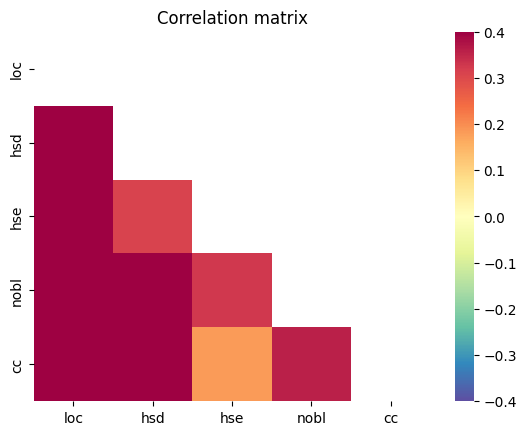

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming subset_df is defined
corrs = subset_df[["loc", "hsd", "hse", "nobl", "cc"]].corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True

# Using seaborn for creating the heatmap
sns.heatmap(corrs, cmap='Spectral_r', mask=mask, square=False, vmin=-.4, vmax=.4)
plt.title('Correlation matrix')
plt.show()

In [41]:
# Concatenate the DataFrames with a multi-index
keys = ['All methods', 'Methods 3 < loc < 41', 'Methods 3 < loc < 41, nobl > 0']
result_df = pd.concat([corr_df1, corr_df2, corr_df3], axis=1, keys=keys)
result_df

All methods           Methods 3 < loc < 41            \
                nobl  bl_ratio                 nobl  bl_ratio   
cc          0.356849  0.105610             0.153990 -0.047023   
nobl        1.000000  0.439375             1.000000  0.805483   
loc         0.726390  0.173667             0.473262  0.106323   
hse         0.325400  0.025680             0.373736  0.114394   
hsd         0.523015  0.225330             0.258775  0.076665   
hsv         0.584066  0.119666             0.456790  0.162911   
coco        0.301803  0.073861             0.182687 -0.036827   
midx       -0.583841 -0.089628            -0.259818 -0.053267   
nocl        0.568640  0.206469             0.395997  0.271477   
bl_ratio    0.439375  1.000000             0.805483  1.000000   
cl_ratio    0.102246  0.206260             0.263438  0.281637   

         Methods 3 < loc < 41, nobl > 0            
                                   nobl  bl_ratio  
cc                             0.175396 -0.296538  
nobl                           1.000000  0.473201  
loc                            0.477421 -0.425293  
hse                            0.344160 -0.215065  
hsd                            0.231224 -0.216649  
hsv                            0.429301 -0.284609  
coco                           0.161808 -0.327159  
midx                          -0.288314  0.116340  
nocl                           0.402492  0.194505  
bl_ratio                       0.473201  1.000000  
cl_ratio                       0.260158  0.312779

### Results

- nobl явно коррелирует с loc, даже в методах, где требуется обязательно хотя бы 1 пустая строка (коэфф > 0.5)
- nobl сильно коррелирует с hs* метриками за счет того, что метода становятся не витиеватыми, а перенасыщенными вызывами и внутренней работой (коэфф около 0.3)
- нужно проверить с чем коррелирует nobl, **невелировав** влияние loc, потому что это известная зависимость

#### Look at partial correlation, controlling loc parametr

In [42]:
control = 'loc'
features = ['nobl', 'bl_ratio', 'cl_ratio']
metrics = ['cc', 'coco', 'hse', 'hsv', 'hsd', 'midx']

partial_correlations = []
# Iterate through feature and metric combinations
for feature in features:
    for metric in metrics:
        # Calculate partial correlation
        partial_corr = pg.partial_corr(data=subset_df, x=metric, y=feature, x_covar=control)
        partial_corr['feature'] = feature
        partial_corr['metric'] = metric
        partial_correlations.append(partial_corr)

print("Correlation between method's property and metric of the code complexity, controlling loc value. All methods")
result_partial_corr = pd.concat(partial_correlations)
result_partial_corr.set_index(['feature', 'metric'], inplace=True)
result_partial_corr

/Users/rmgaliullin/cam_data_600k/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


LinAlgError: Eigenvalues did not converge

In [43]:
partial_correlations_3_40 = []
# Iterate through feature and metric combinations
for feature in features:
    for metric in metrics:
        # Calculate partial correlation
        partial_corr = pg.partial_corr(data=subset_df_3_40, x=metric, y=feature, x_covar=control)
        partial_corr['feature'] = feature
        partial_corr['metric'] = metric
        partial_correlations_3_40.append(partial_corr)

print("Correlation between method's property and metric of the code complexity, controlling loc value. Methods 3 < loc < 41")
result_partial_corr_3_40 = pd.concat(partial_correlations_3_40)
result_partial_corr_3_40.set_index(['feature', 'metric'], inplace=True)
result_partial_corr_3_40

Correlation between method's property and metric of the code complexity, controlling loc value. Methods 3 < loc < 41


n         r           CI95%          p-val
feature  metric                                                 
nobl     cc      141204 -0.167151  [-0.17, -0.16]   0.000000e+00
         coco    141204 -0.130322  [-0.14, -0.13]   0.000000e+00
         hse     141204  0.069256    [0.06, 0.07]  1.172345e-149
         hsv     141204  0.125534    [0.12, 0.13]   0.000000e+00
         hsd     141204  0.011406    [0.01, 0.02]   1.817291e-05
         midx    141204 -0.029799  [-0.04, -0.02]   4.086255e-29
bl_ratio cc      141204 -0.140182  [-0.15, -0.14]   0.000000e+00
         coco    141204 -0.127097  [-0.13, -0.12]   0.000000e+00
         hse     141204  0.057209    [0.05, 0.06]  1.129600e-102
         hsv     141204  0.130871    [0.13, 0.14]   0.000000e+00
         hsd     141204  0.024353    [0.02, 0.03]   5.565942e-20
         midx    141204 -0.000823    [-0.01, 0.0]   7.571709e-01
cl_ratio cc      141204 -0.050726  [-0.06, -0.05]   4.186800e-81
         coco    141204 -0.022801  [-0.03, -0.02]   1.042769e-17
         hse     141204 -0.007262   [-0.01, -0.0]   6.352778e-03
         hsv     141204 -0.000494    [-0.01, 0.0]   8.527262e-01
         hsd     141204 -0.019710  [-0.02, -0.01]   1.290826e-13
         midx    141204 -0.049369  [-0.05, -0.04]   6.448571e-77

In [44]:
partial_correlations_3_40_with_non_zero_bl = []
# Iterate through feature and metric combinations
for feature in features:
    for metric in metrics:
        # Calculate partial correlation
        partial_corr = pg.partial_corr(data=subset_df_3_40_with_non_zero_bl, x=metric, y=feature, x_covar=control)
        partial_corr['feature'] = feature
        partial_corr['metric'] = metric
        partial_correlations_3_40_with_non_zero_bl.append(partial_corr)

print("Correlation between method's property and metric of the code complexity, controlling loc value. Methods 3 < loc < 41, nobl > 0")
result_partial_corr_3_40_with_non_zero_bl = pd.concat(partial_correlations_3_40_with_non_zero_bl)
result_partial_corr_3_40_with_non_zero_bl.set_index(['feature', 'metric'], inplace=True)
result_partial_corr_3_40_with_non_zero_bl

Correlation between method's property and metric of the code complexity, controlling loc value. Methods 3 < loc < 41, nobl > 0


n         r           CI95%          p-val
feature  metric                                                
nobl     cc      45889 -0.098782  [-0.11, -0.09]  7.417450e-100
         coco    45889 -0.139829  [-0.15, -0.13]  4.750322e-199
         hse     45889  0.058284    [0.05, 0.07]   7.894717e-36
         hsv     45889  0.089692     [0.08, 0.1]   1.366908e-82
         hsd     45889 -0.004700    [-0.01, 0.0]   3.140779e-01
         midx    45889 -0.056237  [-0.07, -0.05]   1.805163e-33
bl_ratio cc      45889 -0.078861  [-0.09, -0.07]   3.253409e-64
         coco    45889 -0.099704  [-0.11, -0.09]  1.058437e-101
         hse     45889  0.065393    [0.06, 0.07]   1.129824e-44
         hsv     45889  0.077090    [0.07, 0.09]   1.957802e-61
         hsd     45889 -0.008079    [-0.02, 0.0]   8.353507e-02
         midx    45889 -0.112353   [-0.12, -0.1]  8.744344e-129
cl_ratio cc      45889 -0.058499  [-0.07, -0.05]   4.407702e-36
         coco    45889 -0.045654  [-0.05, -0.04]   1.311440e-22
         hse     45889 -0.020828  [-0.03, -0.01]   8.121365e-06
         hsv     45889 -0.030514  [-0.04, -0.02]   6.236008e-11
         hsd     45889 -0.043094  [-0.05, -0.03]   2.573576e-20
         midx    45889 -0.062373  [-0.07, -0.05]   8.598759e-41

In [45]:
# Concatenate the DataFrames with a multi-index
keys = ['All methods', 'Methods 3 < loc < 41', 'Methods 3 < loc < 41, nobl > 0']
result_partial_corr_df = pd.concat([result_partial_corr.loc[:, 'r'], result_partial_corr_3_40.loc[:, 'r'], result_partial_corr_3_40_with_non_zero_bl.loc[:, 'r']], axis=1, keys=keys)
result_partial_corr_df

NameError: name 'result_partial_corr' is not defined

### Results

- коэфф корелляции nobl и hsv = 0.12 в Methods 3 < loc < 41	и Methods 3 < loc < 41, nobl > 0
- коэфф корелляции bl_ratio и hsv = 0.12 в Methods 3 < loc < 41	и Methods 3 < loc < 41, nobl > 0
- отрицательная корреляция nobl/bl_ratio с cc обясняется тем, что условные операторы/switch не разбиваются пробелами
- коэфф корелляции bl_ratio и hsd = 0.16 в All methods

In [46]:
correlation_results = []

for column in ['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nobl', 'nocl']:
    correlation_coefficient_nobl, _ = spearmanr(subset_df['nobl'], subset_df[column])
    correlation_coefficient_bl_ratio, _ = spearmanr(subset_df['bl_ratio'], subset_df[column])
    
    correlation_results.append({
            'metric': column,
            'nobl_Coefficient': correlation_coefficient_nobl,
            'bl_ratio': correlation_coefficient_bl_ratio,
        })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.set_index('metric', inplace=True)
correlation_df

,nobl_Coefficient,bl_ratio
metric,,
cc,0.447345,NaN
loc,0.553372,NaN
hse,0.504927,NaN
hsd,0.423918,NaN
hsv,0.513503,NaN
coco,0.443867,NaN
midx,-0.385191,NaN
nobl,1.000000,NaN
nocl,0.404724,NaN


In [47]:
correlation_results = []

for column in ['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nobl', 'nocl']:
    correlation_coefficient_nobl, _ = spearmanr(subset_df_3_40['nobl'], subset_df_3_40[column])
    correlation_coefficient_bl_ratio, _ = spearmanr(subset_df_3_40['bl_ratio'], subset_df_3_40[column])
    
    correlation_results.append({
            'metric': column,
            'nobl_Coefficient': correlation_coefficient_nobl,
            'bl_ratio': correlation_coefficient_bl_ratio,
        })


correlation_df_3_40 = pd.DataFrame(correlation_results)
correlation_df_3_40.set_index('metric', inplace=True)
correlation_df_3_40

,nobl_Coefficient,bl_ratio
metric,,
cc,0.093575,-0.011018
loc,0.409578,0.239197
hse,0.400762,0.268021
hsd,0.243783,0.144664
hsv,0.435760,0.301428
coco,0.088525,-0.019222
midx,-0.260622,-0.132117
nobl,1.000000,0.962762
nocl,0.301002,0.244756


In [48]:
correlation_results = []

for column in ['cc', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nobl', 'nocl']:
    correlation_coefficient_nobl, _ = spearmanr(subset_df_3_40_with_non_zero_bl['nobl'], subset_df_3_40_with_non_zero_bl[column])
    correlation_coefficient_bl_ratio, _ = spearmanr(subset_df_3_40_with_non_zero_bl['bl_ratio'], subset_df_3_40_with_non_zero_bl[column])
    
    correlation_results.append({
            'metric': column,
            'nobl_Coefficient': correlation_coefficient_nobl,
            'bl_ratio': correlation_coefficient_bl_ratio,
        })

correlation_df_3_40_with_non_zero_bl = pd.DataFrame(correlation_results)
correlation_df_3_40_with_non_zero_bl.set_index('metric', inplace=True)
correlation_df_3_40_with_non_zero_bl

,nobl_Coefficient,bl_ratio
metric,,
cc,0.189357,-0.355999
loc,0.476923,-0.527546
hse,0.414332,-0.389069
hsd,0.268804,-0.287236
hsv,0.432299,-0.389289
coco,0.170389,-0.390371
midx,-0.342626,0.253572
nobl,1.000000,0.441521
nocl,0.316858,0.017074


In [49]:
subset_df.reset_index(drop=True)

,cc,nobl,loc,hse,hsd,hsv,coco,midx,nocl,bl_ratio,cl_ratio
0,1,0,-1,258.304,5.333,48.432,0,100.0,0,-0.0,-0.000000
1,2,0,6,3621.689,11.500,314.929,1,100.0,0,0.0,0.000000
2,1,0,11,9038.089,12.833,704.267,0,100.0,4,0.0,0.363636
3,1,0,12,9428.815,13.707,687.888,0,100.0,7,0.0,0.583333
4,1,0,-1,122.042,3.500,34.869,0,100.0,0,-0.0,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...
605961,1,0,1,627.844,13.500,46.507,0,100.0,0,0.0,0.000000
605962,1,0,1,467.023,9.000,51.891,0,100.0,0,0.0,0.000000
605963,1,0,1,340.571,5.000,68.114,0,100.0,0,0.0,0.000000
605964,1,0,1,467.023,9.000,51.891,0,100.0,0,0.0,0.000000


In [50]:
subset_df[subset_df['loc'] > 100].shape[0]

1728

In [51]:
subset_df_3_40_with_non_zero_bl.shape[0]

45889

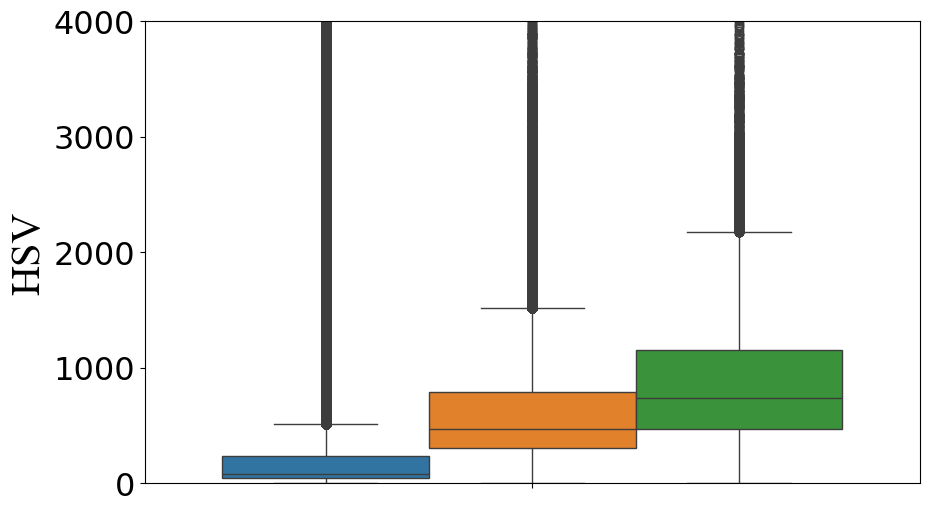

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming your DataFrame is named subset_df_3_40
fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axes

metric = 'hsv'

subset = subset_df[[metric]].assign(Type="any method")
subset_gt_0 = subset_df_3_40[[metric]].assign(Type="any NOBL")
subset_eq_0 = subset_df_3_40_with_non_zero_bl[[metric]].assign(Type="NOBL = 0")

# Concatenate the two subsets
result_df_sub = pd.concat([subset, subset_gt_0, subset_eq_0], ignore_index=True)

# Add another box plot for 'hsd' column where 'nobl' == 0 on the same axis
sns.boxplot(data=result_df_sub, y=metric, hue="Type", ax=ax)

# Set labels and title
ax.set_ylim(bottom=-1, top=4000) 
ax.set_ylabel('HSV', fontdict={'size':30, 'font':'times new roman'})
ax.tick_params(labelsize=23)
ax.get_legend().remove()
plt.show()


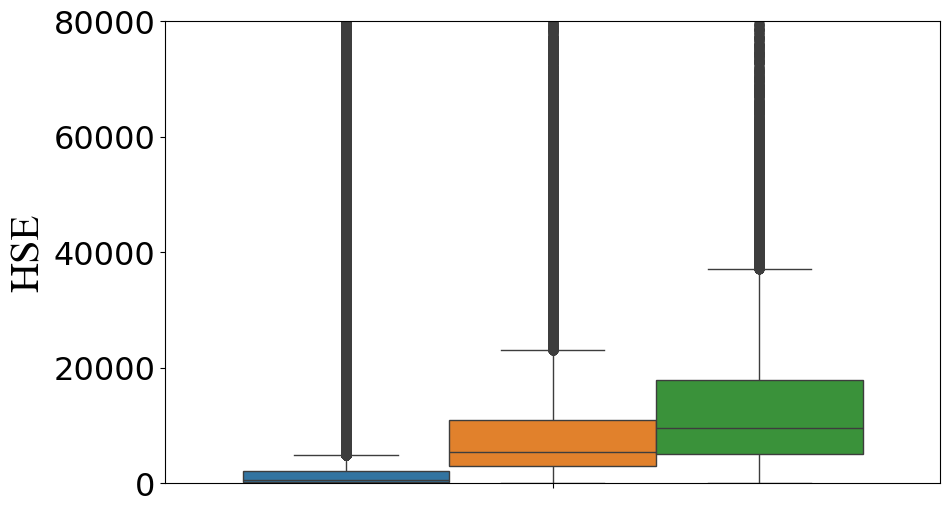

In [53]:
# Assuming your DataFrame is named subset_df_3_40
fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axes

metric = 'hse'

subset = subset_df[[metric]].assign(Type="any method")
subset_gt_0 = subset_df_3_40[[metric]].assign(Type="any NOBL")
subset_eq_0 = subset_df_3_40_with_non_zero_bl[[metric]].assign(Type="NOBL = 0")

# Concatenate the two subsets
result_df_sub = pd.concat([subset, subset_gt_0, subset_eq_0], ignore_index=True)

# Add another box plot for 'hsd' column where 'nobl' == 0 on the same axis
sns.boxplot(data=result_df_sub, y=metric, hue="Type")

# Set labels and title
ax.set_ylim(bottom=-1, top=80000) 
ax.set_ylabel('HSE', fontdict={'size':30, 'font':'times new roman'})
ax.tick_params(labelsize=23)
ax.get_legend().remove()
plt.show()

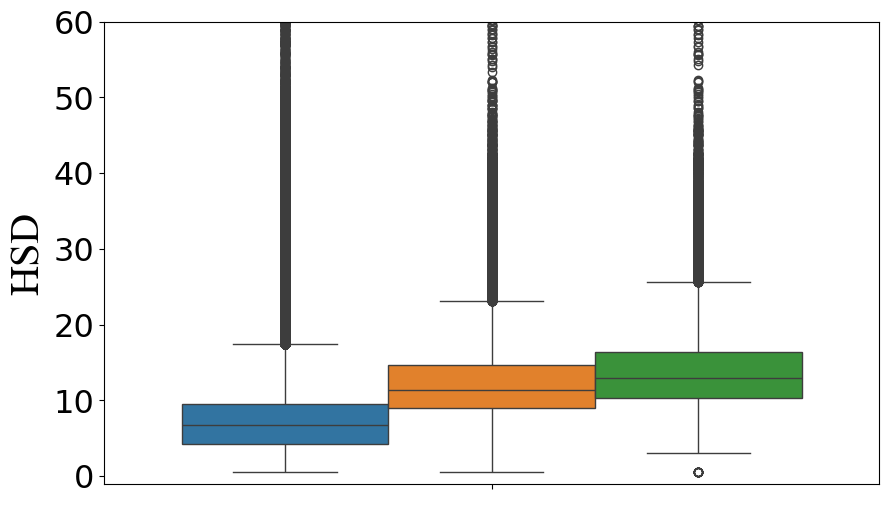

In [54]:
# Assuming your DataFrame is named subset_df_3_40
fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axes

metric = 'hsd'

subset = subset_df[[metric]].assign(Type="any method")
subset_gt_0 = subset_df_3_40[[metric]].assign(Type="any NOBL")
subset_eq_0 = subset_df_3_40_with_non_zero_bl[[metric]].assign(Type="NOBL = 0")

# Concatenate the two subsets
result_df_sub = pd.concat([subset, subset_gt_0, subset_eq_0], ignore_index=True)

# Add another box plot for 'hsd' column where 'nobl' == 0 on the same axis
sns.boxplot(data=result_df_sub, y=metric, hue="Type")

# Set labels and title
ax.set_ylim(bottom=-1, top=60) 
ax.set_ylabel('HSD', fontdict={'size':30, 'font':'times new roman'})
ax.tick_params(labelsize=23)
ax.get_legend().remove()
plt.show()

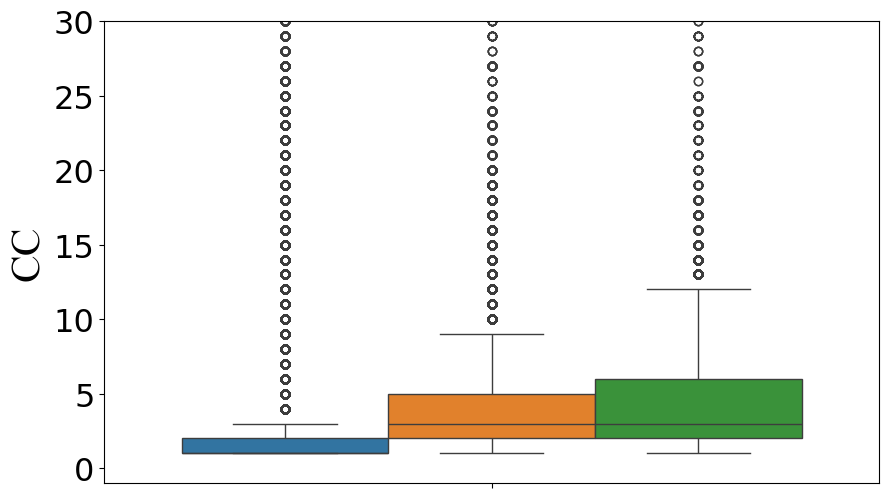

In [55]:
# Assuming your DataFrame is named subset_df_3_40
fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axes

metric = 'cc'

subset = subset_df[[metric]].assign(Type="any method")
subset_gt_0 = subset_df_3_40[[metric]].assign(Type="any NOBL")
subset_eq_0 = subset_df_3_40_with_non_zero_bl[[metric]].assign(Type="NOBL = 0")

# Concatenate the two subsets
result_df_sub = pd.concat([subset, subset_gt_0, subset_eq_0], ignore_index=True)

# Add another box plot for 'hsd' column where 'nobl' == 0 on the same axis
sns.boxplot(data=result_df_sub, y=metric, hue="Type")

# Set labels and title
ax.set_ylim(bottom=-1, top=30) 
ax.set_ylabel('CC', fontdict={'size':30, 'font':'times new roman'})
ax.tick_params(labelsize=23)
ax.get_legend().remove()
plt.show()

In [34]:
# Assuming your DataFrames are named subset_df_3_40_nobl_gt_0 and subset_df_3_40_nobl_eq_0
subset_gt_0 = subset_df_3_40[subset_df_3_40['nobl'] > 0][['cc']].assign(Type=1)  # Assign a Type of 1 for 'nobl' > 0
subset_eq_0 = subset_df_3_40[subset_df_3_40['nobl'] == 0][['cc']].assign(Type=0)  # Assign a Type of 0 for 'nobl' == 0

# Concatenate the two subsets
result_df = pd.concat([subset_gt_0, subset_eq_0], ignore_index=True)

# Display the resulting DataFrame
result_df

,cc,Type
0,2,1
1,2,1
2,2,1
3,2,1
4,1,1
...,...,...
187170,2,0
187171,2,0
187172,2,0
187173,2,0


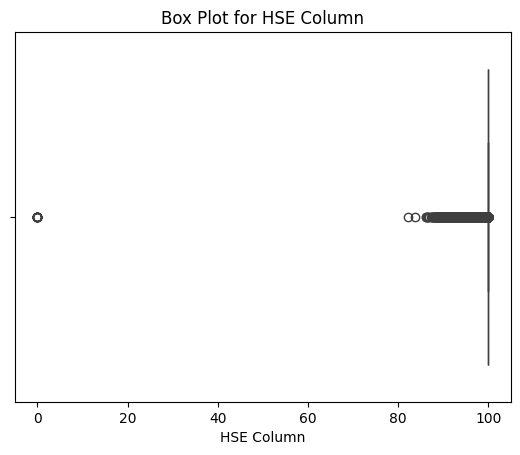

In [35]:
# subset_df_3_40[subset_df_3_40['nobl'] > 0]['cc'].median()
# Assuming your DataFrame is named df
# sns(style="whitegrid")  # Set the style of the seaborn plot

# Create a box plot for the 'hse' column
sns.boxplot(x=subset_df_3_40['midx'])

# Set labels and title
plt.xlabel('HSE Column')
plt.title('Box Plot for HSE Column')

# Show the plot
plt.show()

In [36]:
subset_df['bl_ratio']

17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
         ... 
605995    0.0
605996    0.0
605997    0.0
605998    0.0
605999    0.0
Name: bl_ratio, Length: 605966, dtype: float64

In [37]:
from tqdm import tqdm
import os

mapping = {'bl_ratio':'robl', 'cl_ratio':'rocl', 'nocl':'ncl', 'hse':'hse', 'hsd':'hsd', 'hsv':'hsv'}
data = {'groupA':subset_df,'groupB': subset_df_3_40,'groupC':subset_df_3_40_with_non_zero_bl}


for i in tqdm(['cc', 'nobl', 'loc', 'hse', 'hsd', 'hsv', 'coco', 'midx', 'nocl', 'bl_ratio', 'cl_ratio']):
    for group, subset in data.items():
        if i != 'nobl':
            file_name = f'/Users/rmgaliullin/cam_data_600k/big/{group}_nobl_{i}.csv'
            result_df = pd.DataFrame(subset[['nobl', i]].drop_duplicates(), columns=['nobl', i])
            result_df.to_csv(file_name, index=False, sep=' ')

        if i != 'loc':
            file_name = f'/Users/rmgaliullin/cam_data_600k/big/{group}_loc_{i}.csv'
            result_df = pd.DataFrame(subset[['loc', i]].drop_duplicates(), columns=['loc', i])
            result_df.to_csv(file_name, index=False, sep=' ')


        if i != 'bl_ratio':
            file_name = f'/Users/rmgaliullin/cam_data_600k/big/{group}_robl_{i}.csv'
            result_df = pd.DataFrame(subset[['bl_ratio', i]].drop_duplicates(), columns=['robl', i])
            result_df.to_csv(file_name, index=False, sep=' ')


100%|██████████| 11/11 [00:01<00:00,  5.95it/s]


In [38]:
subset_df[subset_df['bl_ratio'] > 4]

,cc,nobl,loc,hse,hsd,hsv,coco,midx,nocl,bl_ratio,cl_ratio
180615,1,9,2,75.799,3.0,25.266,0,100.0,3,4.5,1.5


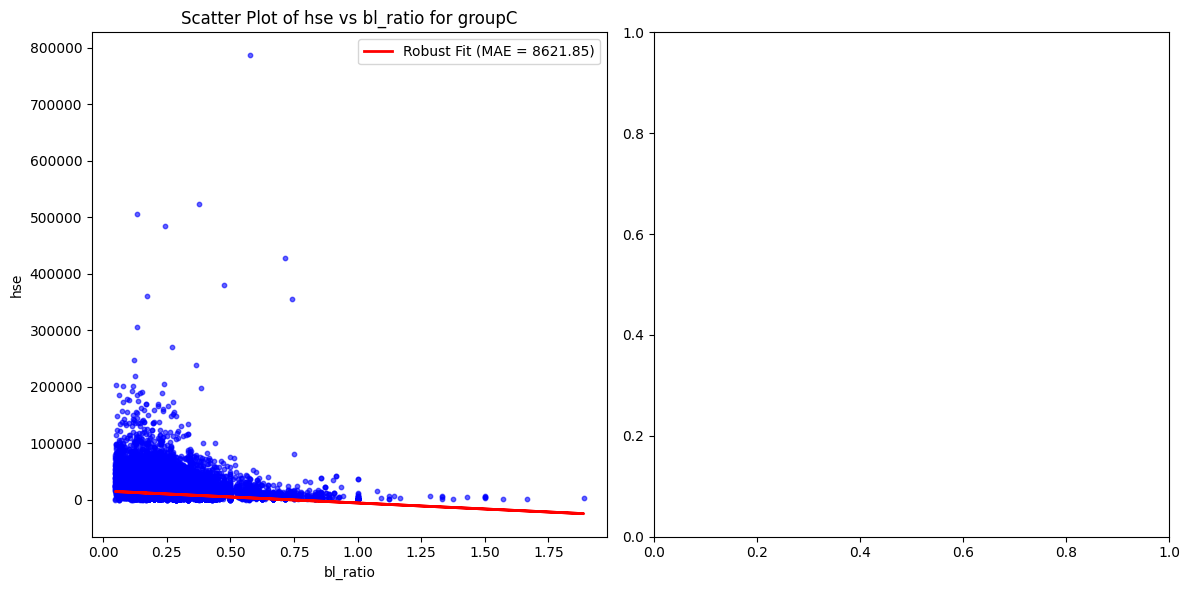

,robl,hse,count
0,0.166667,101805,1
1,0.700000,6600,1
2,0.500000,2300,1
3,0.170732,68218,1
4,0.051282,84628,1
...,...,...,...
1936,0.234875,4134,164
1937,0.253466,2962,165
1938,0.242974,3321,170
1939,0.245135,3106,175


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error

# Parameters and Data Import
xaxis = 'bl_ratio'
yaxis = 'hse'
group = 'groupC'
data = {'groupA': subset_df, 'groupB': subset_df_3_40, 'groupC': subset_df_3_40_with_non_zero_bl}
file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_robl_{yaxis}.csv'
result_df_from_file = pd.read_csv(file_name, sep=' ')

# Apply column mapping to result_df_from_file
mapping = {'bl_ratio': 'robl', 'cl_ratio': 'rocl', 'nocl': 'ncl', 'hse': 'hse', 'hsd': 'hsd', 'hsv': 'hsv'}
result_df_from_file.rename(columns=mapping, inplace=True)

# Update xaxis and yaxis to reflect renamed columns
xaxis_mapped = mapping.get(xaxis, xaxis)  # Use mapped column name if exists
yaxis_mapped = mapping.get(yaxis, yaxis)

# Create Subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter Plot and Linear Regression for First Plot
axs[0].scatter(data[group][xaxis], data[group][yaxis], s=10, alpha=0.6, color='blue')
axs[0].set_xlabel(xaxis)
axs[0].set_ylabel(yaxis)
axs[0].set_title(f"Scatter Plot of {yaxis} vs {xaxis} for {group}")

# Robust Linear Regression and MAE for First Plot
X = data[group][[xaxis]]
y = data[group][yaxis]
huber = HuberRegressor().fit(X, y)
y_hat = huber.predict(X)
mae = mean_absolute_error(y, y_hat)
axs[0].plot(data[group][xaxis], y_hat, color='red', linewidth=2, label=f'Robust Fit (MAE = {mae:.2f})')
axs[0].legend()

# Scatter Plot and Linear Regression for Second Plot (from file)
# x_values = result_df_from_file[xaxis_mapped]
# y_values = result_df_from_file[yaxis_mapped]
# scatter = axs[1].scatter(x_values, y_values, s=result_df_from_file['count'] * 8, c=result_df_from_file['count'], cmap='tab20b', alpha=0.5)
# axs[1].set_xlabel(xaxis_mapped)
# axs[1].set_ylabel(yaxis_mapped)
# axs[1].set_title(f"Scatter Plot of {yaxis_mapped} vs {xaxis_mapped} with Counts as Size")

# # Linear Regression for Second Plot (from file)
# slope_file, intercept_file, _, _, _ = linregress(x_values, y_values)
# y_hat_file = slope_file * x_values + intercept_file
# axs[1].plot(x_values, y_hat_file, color='red', linewidth=2, label='Linear Fit')
# axs[1].legend()

# # Add Colorbar for 'Count' in Second Plot
# cbar = fig.colorbar(scatter, ax=axs[1], label='Count')

# Show the Plot
plt.tight_layout()
plt.show()

result_df_from_file


In [39]:
df = subset_df_3_40_with_non_zero_bl.copy()
for column in df.columns:
    try:
        df[column+'_transformed'], _ = stats.boxcox(df[column])
    except Exception:
        pass

features = ['loc_transformed','nobl_transformed', 'bl_ratio_transformed', 'cl_ratio_transformed']
metrics = ['cc_transformed', 'coco_transformed', 'hse_transformed', 'hsv_transformed', 'hsd_transformed', 'midx_transformed']

partial_correlations_3_40_with_non_zero_bl = []
# Iterate through feature and metric combinations
for feature in features:
    for metric in metrics:
        # Calculate partial correlation
        try:
            partial_corr = pg.partial_corr(data=df, x=metric, y=feature, x_covar=control)
            partial_corr['feature'] = feature
            partial_corr['metric'] = metric
            partial_correlations_3_40_with_non_zero_bl.append(partial_corr)
        except Exception:
            pass

print("Correlation between method's property and metric of the code complexity, controlling loc value. Methods 3 < loc < 41, nobl > 0")
result_partial_corr_3_40_with_non_zero_bl = pd.concat(partial_correlations_3_40_with_non_zero_bl)
result_partial_corr_3_40_with_non_zero_bl.set_index(['feature', 'metric'], inplace=True)
result_partial_corr_3_40_with_non_zero_bl

Correlation between method's property and metric of the code complexity, controlling loc value. Methods 3 < loc < 41, nobl > 0


n         r           CI95%  \
feature              metric                                             
loc_transformed      cc_transformed   48185  0.031855    [0.02, 0.04]   
                     hse_transformed  48185  0.062550    [0.05, 0.07]   
                     hsv_transformed  48185  0.068273    [0.06, 0.08]   
                     hsd_transformed  48185  0.034273    [0.03, 0.04]   
nobl_transformed     cc_transformed   48185 -0.063130  [-0.07, -0.05]   
                     hse_transformed  48185  0.075054    [0.07, 0.08]   
                     hsv_transformed  48185  0.096069     [0.09, 0.1]   
                     hsd_transformed  48185  0.020697    [0.01, 0.03]   
bl_ratio_transformed cc_transformed   48185 -0.124044  [-0.13, -0.12]   
                     hse_transformed  48185 -0.011732   [-0.02, -0.0]   
                     hsv_transformed  48185  0.007175    [-0.0, 0.02]   
                     hsd_transformed  48185 -0.034177  [-0.04, -0.03]   

                                              p-val  
feature              metric                          
loc_transformed      cc_transformed    2.672389e-12  
                     hse_transformed   5.580316e-43  
                     hsv_transformed   6.957839e-51  
                     hsd_transformed   5.265890e-14  
nobl_transformed     cc_transformed    9.482620e-44  
                     hse_transformed   3.799164e-61  
                     hsv_transformed   3.680242e-99  
                     hsd_transformed   5.531190e-06  
bl_ratio_transformed cc_transformed   1.693479e-164  
                     hse_transformed   1.001732e-02  
                     hsv_transformed   1.152825e-01  
                     hsd_transformed   6.180921e-14

In [78]:
def dist2(p1, p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2

def fuse(points, d):
    # random.shuffle(points)
    ret = []
    d2 = d * d
    n = len(points)

    taken = [False] * n
    for i, point in enumerate(points):
        
        if points[i][0] > 3:
            print(f"This point {point} is taken {taken[i]}")
        if not taken[i]:
            count = 1
            taken[i] = True
            x_mid = point[0]
            y_mid = point[1]
            for j in range(i+1, n):
                if not taken[j] and dist2((x_mid / count, y_mid / count), points[j]) < d2:
                    if points[j][0] > 3:
                        print(f"REMOVE 4+ robl reason: dist {points[j]} and {(x_mid / count, y_mid / count)} d2={d2} there dist={ dist2((x_mid / count, y_mid / count), points[j])}")
                    count+=1
                    taken[j] = True
                    x_mid += points[j][0]
                    y_mid += points[j][1]
            if points[i][0] > 3:
                print(f"Write result {(x_mid / count, y_mid / count, count)}")
            ret.append((x_mid / count, y_mid / count, count))
    return ret

def find_best(points, base, split=1000000, d=None, count=350):
    if d is None:
        d = dist2(points[0], points[-1]) / split
    working_version = points[:]
    res = fuse(working_version, d)
    while (len(res) > count):
        print(f"Current d = {d}, size of data = {len(res)}, max = {max(res)}")
        d *= base
        res = fuse(working_version, d)
    return res, d

nobl_subset_df_sorted = subset_df.sort_values(by='nobl')
nobl_subset_df_3_40_sorted = subset_df_3_40.sort_values(by='nobl').copy()
nobl_subset_df_3_40_with_non_zero_bl_sorted = subset_df_3_40_with_non_zero_bl.sort_values(by='nobl').copy()

loc_subset_df_sorted = subset_df.sort_values(by='loc').copy()
loc_subset_df_3_40_sorted = subset_df_3_40.sort_values(by='loc').copy()
loc_subset_df_3_40_with_non_zero_bl_sorted = subset_df_3_40_with_non_zero_bl.sort_values(by='loc').copy()

robl_subset_df_sorted = robl_subset_df.sort_values(by='bl_ratio').copy()
robl_subset_df_3_40_sorted = robl_subset_df_3_40.sort_values(by='bl_ratio').copy()
robl_subset_df_3_40_with_non_zero_bl_sorted = robl_subset_df_3_40_with_non_zero_bl.sort_values(by='bl_ratio').copy()


In [82]:
robl_subset_df[robl_subset_df['bl_ratio'] == 11]

,cc,loc,hse,hsd,hsv,coco,midx,nocl,bl_ratio,cl_ratio
121649,1,1,122.042,3.5,34.869,0,100.0,14,11.0,14.0


In [85]:
mapping = {'bl_ratio':'robl', 'cl_ratio':'rocl', 'nocl':'ncl', 'hse':'hse', 'hsd':'hsd', 'hsv':'hsv'}
data = {'groupA':robl_subset_df_sorted,'groupB': subset_df_3_40,'groupC':subset_df_3_40_with_non_zero_bl}
distance_map = {'hse': 100, 'hsv': 10, 'hsd': 1}
# done cc
# tdb 'nobl', 'loc', 'coco', 'midx', 'nocl', 'bl_ratio', 'cl_ratio', hse, hsd, hsv,  'midx', 'nocl'
for i in tqdm(['hse']):
    for group, subset in data.items():
        
        # if i != 'nobl':
        #     file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_nobl_{mapping.get(i, i)}.csv'
        #     best_values, distance = find_best(subset[['nobl', i]].drop_duplicates().values, 1.002, d=1.00002, count=3000)
        #     best_values.sort(key=lambda x:x[-1])
        #     result_df_from_file = pd.read_csv(file_name, sep=' ')
        #     more = len(best_values) > result_df_from_file.shape[0]
        #     if more:
        #         result_df = pd.DataFrame(best_values, columns=['nobl', mapping.get(i, i), 'count'])
        #         result_df[mapping.get(i, i)] = result_df[mapping.get(i, i)].astype(int)
        #         result_df.to_csv(file_name, index=False, sep=' ')
            
        #     print(f"Done NOBL {i} number of points is {len(best_values)} and distance is {distance} in group {group}. It is more {more} than was")

        # if i != 'loc':
        #     file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_loc_{mapping.get(i, i)}.csv'
        #     best_values, distance = find_best(subset[['loc', i]].drop_duplicates().values, 2, d=0.02, count=3000)
        #     best_values.sort(key=lambda x:x[-1])
        #     result_df_from_file = pd.read_csv(file_name, sep=' ')
        #     more = len(best_values) > result_df_from_file.shape[0]
        #     if more:
        #         result_df = pd.DataFrame(best_values, columns=['loc', mapping.get(i, i), 'count'])
        #         result_df[mapping.get(i, i)] = result_df[mapping.get(i, i)].astype(int)
        #         result_df.to_csv(file_name, index=False, sep=' ')
        #     print(f"Done LOC {i} number of points is {len(best_values)} and distance is {distance} in group {group}. It is more {more} than was")

        if i != 'bl_ratio':
            file_name = f'/Users/rmgaliullin/cam_data_600k/small/{group}_robl_{mapping.get(i, i)}.csv'
            best_values, distance = find_best(subset[['bl_ratio', i]].drop_duplicates().values, 1.5, d=3, count=3000)
            best_values.sort(key=lambda x:x[-1])
            # result_df_from_file = pd.read_csv(file_name, sep=' ')

            more = True
            if more:
                result_df = pd.DataFrame(best_values, columns=['robl', mapping.get(i, i), 'count'])
                result_df[mapping.get(i, i)] = result_df[mapping.get(i, i)].astype(int)
                result_df.to_csv(file_name, index=False, sep=' ')
            
            print(f"Done ROBL {i} number of points is {len(best_values)} and distance is {distance} in group {group}. It is more {more} than was")

  0%|          | 0/1 [00:00<?, ?it/s]

This point [   4.    1092.561] is taken False
Write result (4.0, 1092.561, 1)
This point [   4.    1077.601] is taken False
Write result (4.0, 1077.601, 1)
This point [  4.    139.521] is taken False
Write result (4.0, 139.521, 1)
This point [  5.    345.943] is taken False
Write result (5.0, 345.943, 1)
This point [   5.33333333 2825.013     ] is taken False
Write result (5.333333333333333, 2825.013, 1)
This point [  7.   562.94] is taken False
Write result (7.0, 562.94, 1)
This point [  7.    159.453] is taken False
Write result (7.0, 159.453, 1)
This point [ 11.    122.042] is taken False
Write result (11.0, 122.042, 1)
Current d = 3, size of data = 17026, max = (11.0, 122.042, 1)
REMOVE 4+ robl reason: dist [  4.    139.521] and (0.8571428571428571, 139.0705714285714) d2=20.25 there dist=10.080436918367349
REMOVE 4+ robl reason: dist [   4.    1077.601] and (0.16796788482834996, 1077.2733604651164) d2=20.25 there dist=14.791817796525718
This point [   4.    1092.561] is taken False

100%|██████████| 1/1 [17:40<00:00, 1060.30s/it]

Done ROBL hse number of points is 2296 and distance is 22.78125 in group groupC. It is more True than was


In [86]:
def copy_csv_to_dat(directory, depth=1):
    for root, dirs, files in os.walk(directory):
        current_depth = root[len(directory) + 1:].count(os.sep)
        print("inside")
        if current_depth > depth:
            continue
        for file in files:
            if file.endswith('.csv'):
                csv_file_path = os.path.join(root, file)
                dat_file_path = os.path.join(root, 'dat', file.replace('.csv', '.dat'))
                os.makedirs(os.path.dirname(dat_file_path), exist_ok=True)
                print(f"Copying CSV file '{csv_file_path}' to DAT file '{dat_file_path}'")
                # df_smth = pd.read_csv(csv_file_path, sep=' ')
# Normalize the count column
                # df_smth['count'] = (df_smth['count'] - df_smth['count'].min()) / (df_smth['count'].max() - df_smth['count'].min())

# Write the df_smth data to a new CSV file
                # df_smth.to_csv(csv_file_path, index=False, sep=' ')
                with open(csv_file_path, 'r') as csv_file:
                    csv_content = csv_file.read()
                    with open(dat_file_path, 'w') as dat_file:
                        dat_file.write(csv_content)
                    
    
# Specify the directory path
directory_path = '/Users/rmgaliullin/cam_data_600k/small'

# Call the function to copy CSV files to DAT files at depth=1
copy_csv_to_dat(directory_path, depth=1)


inside
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupB_robl_midx.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupB_robl_midx.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupA_nobl_bl_ratio.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupA_nobl_bl_ratio.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupC_loc_midx.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupC_loc_midx.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupB_nobl_coco.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupB_nobl_coco.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupC_nobl_rocl.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupC_nobl_rocl.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_600k/small/groupC_robl_hsv.csv' to DAT file '/Users/rmgaliullin/cam_data_600k/small/dat/groupC_robl_hsv.dat'
Copying CSV file '/Users/rmgaliullin/cam_data_6